In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

def gini(roc_auc_score):
    return roc_auc_score*2-1

In [2]:
df = pd.read_csv('propensity_dataset.csv')

In [3]:
df.columns

Index(['Hashed_ID', 'land_month', 'land_month_no', 'Tenure',
       'Average_Turnover', 'Average_Trans_Count', 'Times_Marketed_To',
       'Message', 'Xer', 'mcc_rating', 'Pam_Score', 'Industry', 'responded',
       'approved', 'funded'],
      dtype='object')

In [4]:
df = df[['Tenure', 'Average_Turnover', 'Average_Trans_Count', 'Times_Marketed_To', 'Message', 'Xer',
       'mcc_rating', 'Pam_Score', 'responded']]

In [5]:
#remove outcome from features
y = (df['responded'])
X = df.drop('responded', axis = 1)
feature_list = list(X.columns)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X, y), columns = X.columns)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [8]:
import xgboost as xgb
xgbc = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.2,
                max_depth = 5, alpha = 10, n_estimators = 50, scale_pos_weight = 250, n_jobs = -1)

In [9]:
xgbc.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=250, seed=None,
              silent=None, subsample=1, verbosity=1)

In [10]:
preds = xgbc.predict_proba(X_test)[:,1]

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, preds)
print(f'ROC AUC Score = {roc_auc}')
print(f'Gini = {gini(roc_auc)}')

ROC AUC Score = 0.7057185907256185
Gini = 0.411437181451237


# Results from grid searching on Azure resource

Params used:
rdm_params = {

        'min_child_weight': [1, 5, 10],
        
        'gamma': [0.5, 1, 1.5, 2],
        
        'subsample': [0.6, 0.8, 1.0],
        
        'colsample_bytree': [0.6, 0.8, 1.0],
        
        'max_depth': [3, 4, 5],
        
        'scale_pos_weight': [200, 250, 300],
        
        'n_estimators': [50, 75, 100]
        }

In [13]:
import xgboost as xgb
xgbc_best = xgb.XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=1.5, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=75, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=250, seed=None, silent=True,
       subsample=1.0)

In [14]:
xgbc_best.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.5,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=75, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=250, seed=None,
              silent=True, subsample=1.0, verbosity=1)

In [15]:
preds = xgbc_best.predict_proba(X_test)[:,1]

In [16]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, preds)
print(f'ROC AUC Score = {roc_auc}')
print(f'Gini = {gini(roc_auc)}')

ROC AUC Score = 0.7095860178638044
Gini = 0.41917203572760875


In [33]:
test_df = pd.DataFrame(y_test).merge(df.drop('responded', axis = 1), how = 'left', left_index = True, right_index = True)
test_df['pred'] = preds

In [34]:
test_df

,responded,Tenure,Average_Turnover,Average_Trans_Count,Times_Marketed_To,Message,Xer,mcc_rating,Pam_Score,pred
2014655,0,161.0,NaN,NaN,2,0,1.262896,-1,0.089945,0.205632
2760537,0,38.0,NaN,NaN,2,1,0.524241,0,0.178723,0.510317
828509,0,87.0,NaN,NaN,6,0,0.725846,0,0.053128,0.365397
73364,0,NaN,NaN,NaN,1,0,0.935730,0,NaN,0.548783
2665674,0,56.0,13629.00,1210.00,20,0,1.257342,1,0.069650,0.566605
...,...,...,...,...,...,...,...,...,...,...
596779,0,111.0,18533.00,1777.00,24,1,0.770084,0,0.089945,0.468026
1635610,0,11.0,41362.00,1056.00,8,0,NaN,0,0.108942,0.634585
1507617,0,15.0,9398.00,1073.00,9,1,0.829797,1,0.093595,0.770148
1454487,0,245.0,62224.58,56.55,26,0,0.380224,0,0.088074,0.163990


In [314]:
test_df['pred_decile'] = pd.qcut(test_df['pred'], 10, labels = False)

Text(3, 0.012, 'Gini = 0.42')

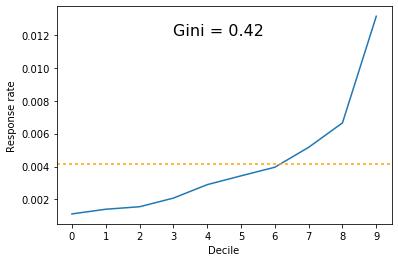

In [36]:
import matplotlib.pyplot as plt
plt.plot(test_df.groupby('pred_decile')['responded'].mean())
plt.axhline(test_df['responded'].mean(), color = 'orange', dashes = [2, 2])
plt.xticks(np.arange(0,10))
plt.xlabel('Decile')
plt.ylabel('Response rate')
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
plt.text(x = 3, y = 0.012, s= 'Gini = 0.42', fontdict = font)

In [22]:
import pickle
pickle.dump(xgbc_best, open('xgb_propensity.pkl', 'wb'))

In [37]:
test_df.head()

,responded,Tenure,Average_Turnover,Average_Trans_Count,Times_Marketed_To,Message,Xer,mcc_rating,Pam_Score,pred,pred_decile
2014655,0,161.0,NaN,NaN,2,0,1.262896,-1,0.089945,0.205632,0
2760537,0,38.0,NaN,NaN,2,1,0.524241,0,0.178723,0.510317,6
828509,0,87.0,NaN,NaN,6,0,0.725846,0,0.053128,0.365397,3
73364,0,NaN,NaN,NaN,1,0,0.935730,0,NaN,0.548783,7
2665674,0,56.0,13629.0,1210.0,20,0,1.257342,1,0.069650,0.566605,7


In [311]:
from random import random

#lam = (1/96)/(1-np.exp())

def to_be_called(prop, lim):
    call_prob = np.exp((prop-lim)/0.01)**0.5
    if prop >= lim:
        return 1, 1
    else:
        if call_prob > random():
            return 1, call_prob
        else:
            return 0, call_prob

In [305]:
test_df['called'], test_df['call_prob'] = test_df['pred'].apply(lambda x: to_be_called(x, 0.75))

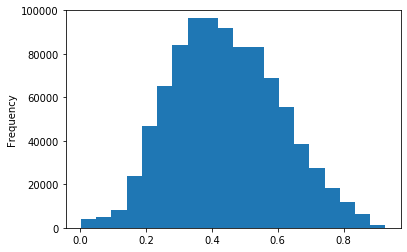

In [306]:
test_df['pred'].plot.hist(bins = 20, ylim = (0, 100000))

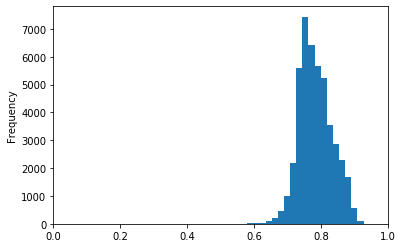

In [307]:
test_df[(test_df['called'] == 1)]['pred'].plot.hist(bins = 20, xlim = (0,1))

In [308]:
len(test_df[(test_df['called'] == 1) & (test_df['pred'] < 0.75)])

12234

In [312]:
len(test_df[(test_df['called'] == 1) & (test_df['pred'] >= 0.75)])

33208

In [262]:
x = 0.0000000000001
lim = 0.75

def prob(x, lim):
    return (1 - ((lim - x)))**2

prob(x, lim)

0.06250000000005002

In [194]:
xrange = range(1,101)
yrange = [prob(i, 0.75) for i in xrange]

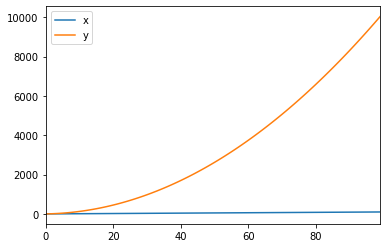

In [195]:
pd.DataFrame({'x':xrange, 'y':yrange}).plot()